# 선형회귀 모델(텐서플로 활용)

In [27]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow.keras import optimizers

In [48]:
# 계속 동일 데이터 생성
np.random.seed(320)
x_train = np.linspace(-1, 1, 51)
y_train = 0.5 * x_train + 1.0 + 0.4 * np.random.rand(len(x_train))
x_train = x_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [50]:
class MyModel(tf.keras.Model): # tf.keras.model 상속
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable(tf.ones([1,1])) # 기울기
        self.b = tf.Variable(tf.ones([1])) # y 절편

    def call(self, x): # x: 데이터 x 좌표
        return tf.matmul(x, self.w) + self.b

In [52]:
loss = lambda y, yhat: tf.reduce_mean(tf.square(y - yhat))

In [54]:
# 예측 모델 설정
model = MyModel()

# 수치최적화 알고리즘 설정
MaxEpoch = 25
lr = 0.25
optimizer = optimizers.SGD(lr)

# 결정론적 방법과 스토캐스틱 방법(뱃치 방법과 미니 뱃치 방법)

## 결정론적 방법

In [56]:
for epoch in range(MaxEpoch):
    with tf.GradientTape() as tape: #텐서연산 기록
        curr_loss = loss(y_train, model(x_train))
        gradients = tape.gradient(curr_loss, model.trainable_variables)
        if epoch % 5 == 0:
            print(model.w.numpy(), model.b.numpy(), curr_loss.numpy())
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

[[1.]] [1.] 0.14998727
[[0.6727577]] [1.1888978] 0.028191052
[[0.54642326]] [1.1948009] 0.015662618
[[0.49765092]] [1.1949854] 0.013800872
[[0.478822]] [1.1949911] 0.013523399


In [70]:
from matplotlib.patches import Rectangle
def visualize_l2(w, b, features, x_train, y_train):
    plt.plot(x_train, y_train, '.k', markerfacecolor='none')
    plt.plot(x_train, np.matmul(features, w) + b, '--k')
    currentAxis = plt.gca()
    for ff, xx,yy in zip(features, x_train, y_train):
        error = np.matmul(ff, w) + b - yy
        currentAxis.add_patch(Rectangle((xx, yy), 
                                        error, error,
                              alpha=0.1, facecolor='gray', edgecolor='k'))
    plt.grid()
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('w={:1.2f}, b={:1.2f}'.format(w[0][0],b[0]))
    plt.show()

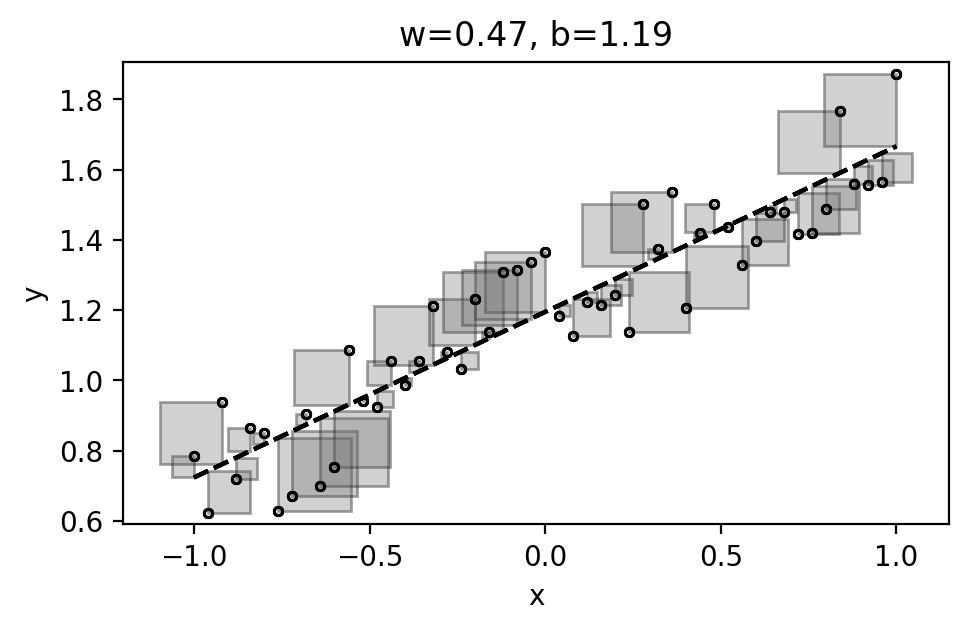

In [72]:
visualize_l2(model.w.numpy(), model.b.numpy(), x_train, x_train, y_train)

## 스토캐스틱 방법

In [87]:
# 데이터 섞기
# x_train과 y_train 따로따로 섞으면 안됨 --> 반드시 같은 위치(짝)
# 선형 회귀나 분류 모델은 “이 입력 x[i]에 대해 정답은 y[i]”라는 관계를 보고 배우는 것.
# 방법 : 인덱스만 섞거나 zip으로 묶어 섞고 다시 풀기
np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = x_train[shuffled_id]
shuffled_y_train = y_train[shuffled_id]

In [81]:
model = MyModel()

MaxEpoch = 25
lr = 0.25
optimizer = optimizers.SGD(lr)
loss = lambda y, yhat: tf.reduce_mean(tf.square(y - yhat))

# 스토캐스틱 방법
def generate_batches(batch_size, features, labels):
    outout_batches = []
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        outout_batches.append(batch)
    return outout_batches

batch_size = 5
for epoch in range(MaxEpoch):

    if epoch % 5 == 0:
        curr_loss = loss(y_train, model(x_train))
        print(model.w.numpy(), model.b.numpy(), curr_loss.numpy())

    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        with tf.GradientTape() as tape:
            curr_loss = loss(y_batch, model(x_batch))
            gradients = tape.gradient(curr_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

[[1.]] [1.] 0.14998727
[[0.4888436]] [1.1834033] 0.0137747675
[[0.48882985]] [1.1833994] 0.013774646
[[0.48882985]] [1.1833994] 0.013774646
[[0.48882985]] [1.1833994] 0.013774646


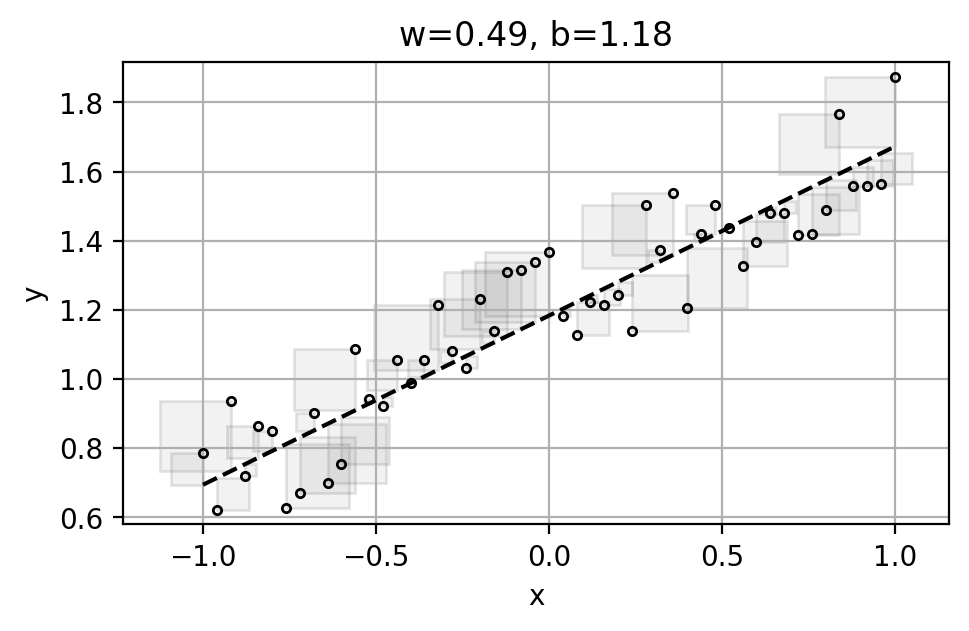

In [83]:
visualize_l2(model.w.numpy(), model.b.numpy(), x_train, x_train, y_train)

# 비선형회귀 모델

## 특성값과 선형회귀 모델을 사용히여 비선형회귀 모델 분석 방법

In [91]:
# 데이터 생성(2차)
np.random.seed(327)
x_train = np.linspace(-1,1,50)
y_train = x_train**2 + 0.25 * x_train + 1.0 + 0.5 * np.random.rand(len(x_train))

In [100]:
# 특성값 정의 --> 적절하게 고안하면 선형회귀 모델로 비선형회귀 분석 가능
features = np.array([[xval**2, xval] for xval in x_train])
labels = y_train.reshape(-1, 1)

In [102]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable(tf.ones([2,1])) 
        self.b = tf.Variable(tf.ones([1])) 

    def call(self, x): # x: 특성값 벡터
        return tf.matmul(x, self.w) + self.b

In [104]:
# 예측 모델 설정
model = MyModel()

# 수치최적화 알고리즘 설정
MaxEpoch = 25
lr = 0.25
batch_size = 10
optimizer = optimizers.SGD(lr)
loss = lambda y, yhat: tf.reduce_mean(tf.square(y - yhat))

In [118]:
# 스토캐스틱 방법
np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = features[shuffled_id]
shuffled_y_train = labels[shuffled_id]

for epoch in range(MaxEpoch):
    if epoch % 5 == 0:
        curr_loss = loss(labels, model(features))
        print(model.w.numpy().T, model.b.numpy(), curr_loss.numpy())

    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        with tf.GradientTape() as tape:
            curr_loss = loss(y_batch, model(x_batch))
            gradients = tape.gradient(curr_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

[[1.0542662  0.23156954]] [1.1799042] 0.01775994
[[1.0541012  0.23157482]] [1.1799741] 0.017758537
[[1.0540481  0.23157656]] [1.1799966] 0.01775809
[[1.0540311  0.23157708]] [1.1800038] 0.017757947
[[1.0540255  0.23157725]] [1.1800061] 0.0177579


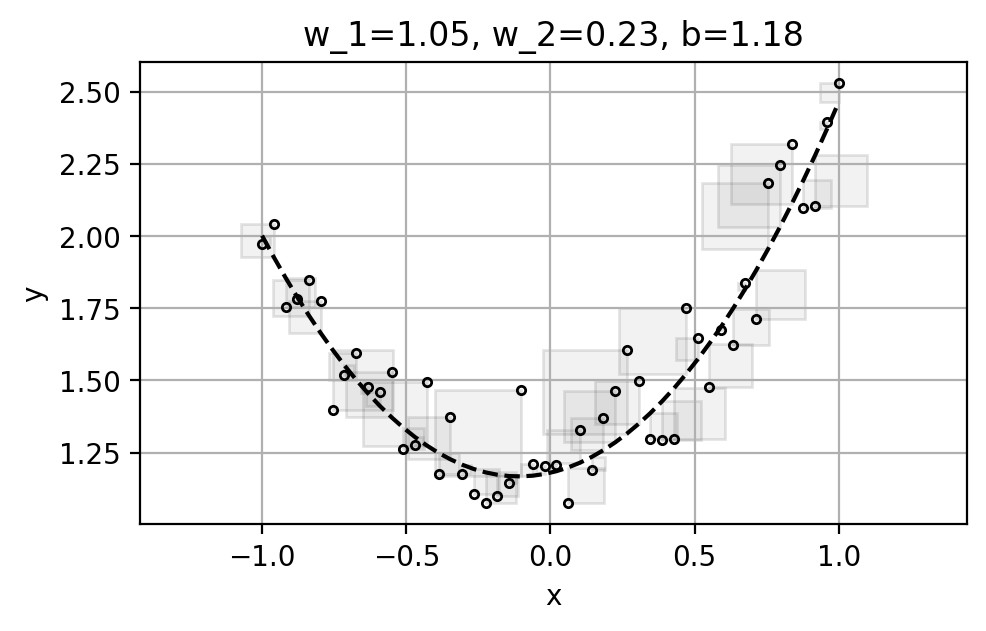

In [130]:
def visualize_l2(w, b, features, x_train, y_train):
    # x_train과 y_train을 1차원 배열로 만듭니다.
    x_train_flat = np.asarray(x_train).flatten()
    y_train_flat = np.asarray(y_train).flatten()

    plt.plot(x_train_flat, y_train_flat, '.k', markerfacecolor='none')

    # 회귀선 계산 시 예측값도 1차원으로 만듭니다.
    # features: (N, num_features), w: (num_features, 1), b: (1,) 또는 스칼라
    # 결과는 (N, 1) 형태이므로 flatten() 사용
    predicted_y_line = (np.matmul(features, w) + b).flatten()
    plt.plot(x_train_flat, predicted_y_line, '--k')

    currentAxis = plt.gca()
    # features의 각 행(ff)과 flatten된 x_train_flat, y_train_flat의 스칼라 값(xx, yy)을 사용합니다.
    for ff, xx, yy in zip(features, x_train_flat, y_train_flat):
        # error 계산:
        # ff: (num_features,)
        # w: (num_features, 1)
        # np.matmul(ff, w) 결과: (1,) 형태의 배열 (예: np.array([value]))
        # b: (1,) 형태의 배열 또는 스칼라
        # yy: 스칼라
        # 최종 error는 (1,) 형태의 배열 (예: np.array([some_error_value]))
        error_val_array = np.matmul(ff, w) + b - yy
        
        # error_val_array[0]은 스칼라 오류 값입니다.
        scalar_error = error_val_array[0]
        
        # xx, yy는 이제 스칼라이므로 Rectangle에 올바르게 전달됩니다.
        currentAxis.add_patch(Rectangle((xx, yy),
                                        scalar_error, scalar_error, # 너비, 높이
                                alpha=0.1, facecolor='gray', edgecolor='k'))
    plt.grid()
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    title_w1 = "N/A"; title_w2 = "N/A"; title_b = "N/A"
    if isinstance(w, np.ndarray) and w.ndim == 2 and w.shape[1] == 1:
        if w.shape[0] >= 1:
            title_w1 = f"{w[0, 0]:1.2f}"
        if w.shape[0] >= 2:
            title_w2 = f"{w[1, 0]:1.2f}" # w의 행이 2개 이상일 때만 접근
    
    if isinstance(b, np.ndarray) and b.size > 0: # b가 배열이고 요소가 있을 때
        title_b = f"{b.item(0):1.2f}" # b[0] 대신 .item(0) 사용 가능 (스칼라 추출)
    elif np.isscalar(b): # b가 스칼라일 때
        title_b = f"{b:1.2f}"
        
    plt.title(f'w_1={title_w1}, w_2={title_w2}, b={title_b}')

visualize_l2(model.w.numpy(), model.b.numpy(), features, x_train, labels)

## 3차 곡선 데이터

In [133]:
# 데이터 생성
np.random.seed(327)
x_train = np.linspace(-1,1,50)
y_train = x_train**3 + 0.1 * x_train**2  -0.15 * x_train + 1.0 + 0.5 * np.random.rand(len(x_train))

In [135]:
# 특성값 정의
features = np.array([[xval**3, xval**2, xval] for xval in x_train])
labels = y_train.reshape(-1, 1)

In [137]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable(tf.ones([3,1])) 
        self.b = tf.Variable(tf.ones([1])) 

    def call(self, x): 
        return tf.matmul(x, self.w) + self.b

In [143]:
# 예측 모델 설정
model = MyModel()

# 수치최적화 알고리즘 설정
MaxEpoch = 25
lr = 0.25
batch_size = 10
optimizer = optimizers.SGD(lr)
loss = lambda y, yhat: tf.reduce_mean(tf.square(y - yhat))

In [145]:
# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = features[shuffled_id]
shuffled_y_train = labels[shuffled_id]

# 스토캐스틱 방법
for epoch in range(MaxEpoch):
    if epoch % 5 == 0:
        curr_loss = loss(labels, model(features))
        print(model.w.numpy().T, model.b.numpy(), curr_loss.numpy())

    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        with tf.GradientTape() as tape:
            curr_loss = loss(y_batch, model(x_batch))
            gradients = tape.gradient(curr_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

[[1. 1. 1.]] [1.] 0.57014674
[[0.57525814 0.42941985 0.10803682]] [1.0714246] 0.031893894
[[0.6731134  0.24562356 0.04974759]] [1.1476407] 0.021883732
[[0.7469721  0.18626072 0.00303175]] [1.1714399] 0.019629695
[[ 0.8040568   0.16686103 -0.03414325]] [1.1785893] 0.018755484


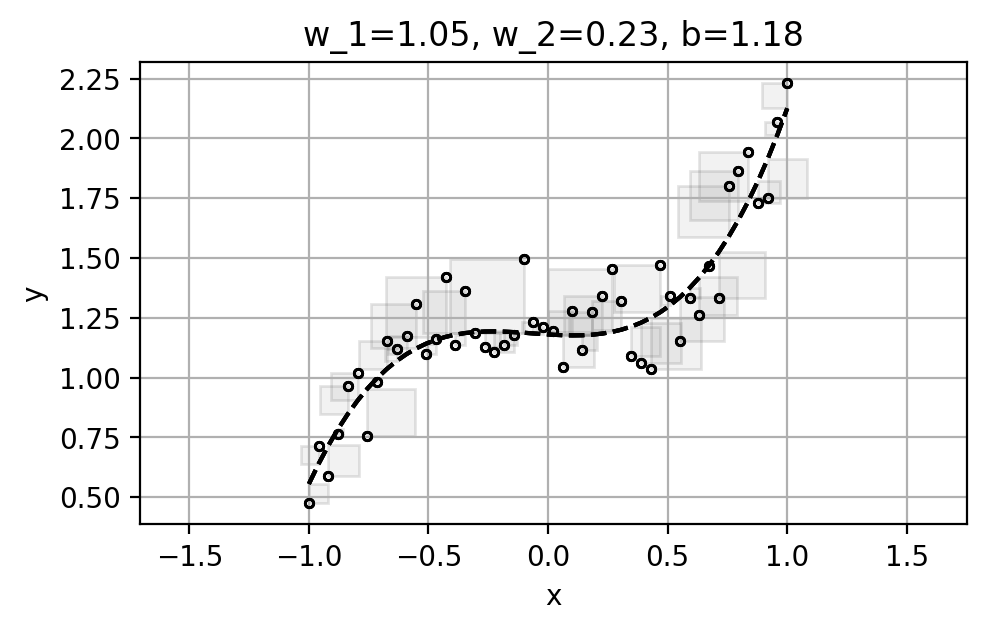

In [151]:
def visualize_l2(w, b, features, x_train, y_train):
    # x_train과 y_train을 1차원 배열로 만듭니다.
    x_train_flat = np.asarray(x_train).flatten()
    y_train_flat = np.asarray(y_train).flatten()

    plt.plot(x_train_flat, y_train_flat, '.k', markerfacecolor='none')

    # 회귀선 계산 시 예측값도 1차원으로 만듭니다.
    # features: (N, num_features), w: (num_features, 1), b: (1,) 또는 스칼라
    # 결과는 (N, 1) 형태이므로 flatten() 사용
    predicted_y_line = (np.matmul(features, w) + b).flatten()
    plt.plot(x_train_flat, predicted_y_line, '--k')

    currentAxis = plt.gca()
    # features의 각 행(ff)과 flatten된 x_train_flat, y_train_flat의 스칼라 값(xx, yy)을 사용합니다.
    for ff, xx, yy in zip(features, x_train_flat, y_train_flat):
        # error 계산:
        # ff: (num_features,)
        # w: (num_features, 1)
        # np.matmul(ff, w) 결과: (1,) 형태의 배열 (예: np.array([value]))
        # b: (1,) 형태의 배열 또는 스칼라
        # yy: 스칼라
        # 최종 error는 (1,) 형태의 배열 (예: np.array([some_error_value]))
        error_val_array = np.matmul(ff, w) + b - yy
        
        # error_val_array[0]은 스칼라 오류 값입니다.
        scalar_error = error_val_array[0]
        
        # xx, yy는 이제 스칼라이므로 Rectangle에 올바르게 전달됩니다.
        currentAxis.add_patch(Rectangle((xx, yy),
                                        scalar_error, scalar_error, # 너비, 높이
                                alpha=0.1, facecolor='gray', edgecolor='k'))
    plt.grid()
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    title_w1 = "N/A"; title_w2 = "N/A"; title_b = "N/A"
    if isinstance(w, np.ndarray) and w.ndim == 2 and w.shape[1] == 1:
        if w.shape[0] >= 1:
            title_w1 = f"{w[0, 0]:1.2f}"
        if w.shape[0] >= 2:
            title_w2 = f"{w[1, 0]:1.2f}" # w의 행이 2개 이상일 때만 접근
    
    if isinstance(b, np.ndarray) and b.size > 0: # b가 배열이고 요소가 있을 때
        title_b = f"{b.item(0):1.2f}" # b[0] 대신 .item(0) 사용 가능 (스칼라 추출)
    elif np.isscalar(b): # b가 스칼라일 때
        title_b = f"{b:1.2f}"
        
    plt.title(f'w_1={title_w1}, w_2={title_w2}, b={title_b}')

visualize_l2(model.w.numpy(), model.b.numpy(), features, x_train, labels)

## 비선형 특성값과 선형 모델 사용 경우 특성값을 정하는 것이 핵심 아이디어

## 특성값을 정하는 것은 사람의 일 --> 비효율적 --> 신경망 모델로 해결 --> 데이터 세트마다 모델을 바꾸지 않아도 특성값을 자동으로 추출